In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule


MODEL_PARAMS = {
"patch_size":16,  # 8, 16, 32, 64, 128
"num_samples": 100,
"target_dim": 1,
"feat_dynamic_real_dim": 0,
"past_feat_dynamic_real_dim": 0,
}

In [2]:
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), "scripts") )

from model_utils import generate_model_input, preprocess_data, get_predictions, plot_results, mean_absolute_percentage_error

root_path = os.path.dirname(os.getcwd())

# Dataset 1

total length: 4581
Index(['bitcoin_price'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

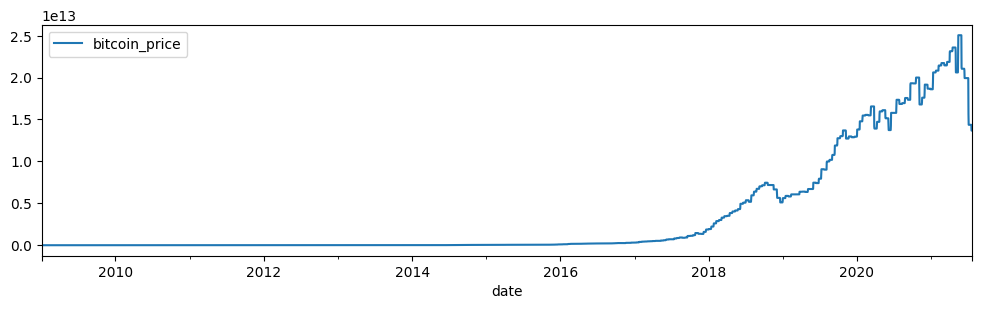

In [3]:
# First: Load dataframe and clean it
df = pd.read_csv(os.path.join(root_path, "data", "bitcoin_values.csv"), parse_dates=True)
date_colname= "date"
target_colname = "bitcoin_price"


df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)


print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

In [7]:
# create the train and test sets
train_window = 12 * 365 # days
prediction_window = 365  # days

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

patches_list = [8, 16, 32, 64, 128]
mape_list = []
time_list = []
for patch in patches_list:
    start_time = time.time()
    # preprocess the data
    target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train[target_colname].values)

    MODEL_PARAMS["patch_size"] = patch
    # Define the model
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length= prediction_window,
        context_length=train_window,
        **MODEL_PARAMS,
    )

    # Make the forecast
    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    # Collect the median forecast and CI into a DataFrame
    predictions_df = get_predictions(
        forecast_tensor=forecast[0],
        train_set=train,
        date_colname=date_colname
    )

    # Merge predictions with original data
    true_and_preds = pd.merge(test, predictions_df, left_index=True, right_index=True, how="right")
    all_data = pd.concat([train.iloc[-200:, :], true_and_preds])

    true_and_preds.dropna(inplace=True)
    mape = mean_absolute_percentage_error(
        y_true=true_and_preds[target_colname].values,
        y_pred=true_and_preds["median_forecast"].values
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    mape_list.append(mape)
    time_list.append(elapsed_time)

In [8]:
mape_batch_size_df = pd.DataFrame(
    {"patch_size": patches_list, "mape": mape_list, "elapsed_time": time_list}
)
mape_batch_size_df

,patch_size,mape,elapsed_time
0,8,85.601334,458.805716
1,16,15.965839,72.203967
2,32,85.863040,7.457570
3,64,85.879407,2.369113
4,128,86.119206,1.409643


# Dataset 2

total length: 1096
Index(['electricity'], dtype='object')
time frequency: 1 days 00:00:00
2012-01-01 00:00:00 2014-12-31 00:00:00


<Axes: xlabel='date'>

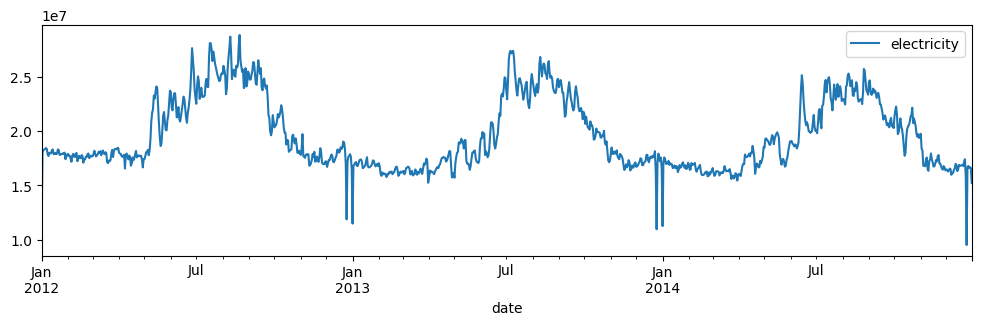

In [10]:
# First: Load dataframe and clean it
df = pd.read_csv(os.path.join(root_path, "data", "electricity_values.csv"), parse_dates=True)
date_colname= "date"
target_colname = "electricity"


df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)


print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

In [12]:
# create the train and test sets
train_window = 2 * 365 # days
prediction_window = 365  # days

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

patches_list = [8, 16, 32, 64, 128]
mape_list = []
time_list = []
for patch in patches_list:
    start_time = time.time()
    # preprocess the data
    target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train[target_colname].values)

    MODEL_PARAMS["patch_size"] = patch
    # Define the model
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length= prediction_window,
        context_length=train_window,
        **MODEL_PARAMS,
    )

    # Make the forecast
    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    # Collect the median forecast and CI into a DataFrame
    predictions_df = get_predictions(
        forecast_tensor=forecast[0],
        train_set=train,
        date_colname=date_colname
    )

    # Merge predictions with original data
    true_and_preds = pd.merge(test, predictions_df, left_index=True, right_index=True, how="right")
    all_data = pd.concat([train.iloc[-200:, :], true_and_preds])

    true_and_preds.dropna(inplace=True)
    mape = mean_absolute_percentage_error(
        y_true=true_and_preds[target_colname].values,
        y_pred=true_and_preds["median_forecast"].values
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    mape_list.append(mape)
    time_list.append(elapsed_time)

In [13]:
mape_batch_size_df = pd.DataFrame(
    {"patch_size": patches_list, "mape": mape_list, "elapsed_time": time_list}
)
mape_batch_size_df

,patch_size,mape,elapsed_time
0,8,15.754340,25.040632
1,16,10.300696,6.726090
2,32,17.893305,3.788573
3,64,26.090480,1.361787
4,128,26.462870,0.953411
